# Week 5 Coursework PCA and MNIST

### 0. Introduction
### 1. Training on MNIST images and getting 95% accuracy
### 2. Decomposing MNIST training dataset into PCA components
### 3. Plot of testing accuracy against N-best PCA components
### 4. Retraining network on 100 best PCA components
### 5. Plot of testing accuracy against 100 N-best PCA components
### 6. Training and plotting of 20 best PCA components
### 7. Conclusion

### 0. Introduction

Principle Component Analysis (PCA) is a dimensionality reduction technique used to summarise large amounts of data into a smaller representation while still maintaining a large degree of accuracy based on the original data.

In this notebook, we will use PCA on the MNIST handrwitten images to determine the optimal number of PCA components required to achieve an acceptable testing accuracy.

In [1]:
#Importing all necessary libraries and plotting commands

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from scipy import linalg # for linear algebra (matrices)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### 1 Training on MNIST images and getting 95% accuracy

Copied from my Week 2 Assignment submission

In [2]:
#Loading the MNIST data
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


#Normalising to 256 pixels
train_images = train_images / 255.0
test_images = test_images / 255.0

N = [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 784]
#N = np.arange(0,784,1)

In [3]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)), #First layer, flatten the 28x28 image into array of length
    #784 (28x28)
    keras.layers.Dense(128, activation = 'relu'), #Dense layer with 128 nodes and ReLu activation function
    keras.layers.Dense(10) #Output layer, 10 nodes corresponding to integers 0:9
])

In [4]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = 1.0), metrics = ['accuracy'])

In [5]:
history = model.fit(train_images, train_labels, batch_size = 100, epochs = 10, 
                    validation_data = (test_images, test_labels))

Epoch 1/10
600/600 [==============================] - 1s 921us/step - loss: 0.3650 - accuracy: 0.8912 - val_loss: 0.1581 - val_accuracy: 0.9517
Epoch 2/10
600/600 [==============================] - 0s 805us/step - loss: 0.1425 - accuracy: 0.9572 - val_loss: 0.1173 - val_accuracy: 0.9637
Epoch 3/10
600/600 [==============================] - 0s 815us/step - loss: 0.1074 - accuracy: 0.9677 - val_loss: 0.1276 - val_accuracy: 0.9622
Epoch 4/10
600/600 [==============================] - 0s 816us/step - loss: 0.0923 - accuracy: 0.9722 - val_loss: 0.1040 - val_accuracy: 0.9689
Epoch 5/10
600/600 [==============================] - 0s 811us/step - loss: 0.0784 - accuracy: 0.9754 - val_loss: 0.1069 - val_accuracy: 0.9697
Epoch 6/10
600/600 [==============================] - 0s 816us/step - loss: 0.0691 - accuracy: 0.9787 - val_loss: 0.1026 - val_accuracy: 0.9701
Epoch 7/10
600/600 [==============================] - 0s 797us/step - loss: 0.0610 - accuracy: 0.9804 - val_loss: 0.1162 - val_accuracy:

<IPython.core.display.Javascript object>


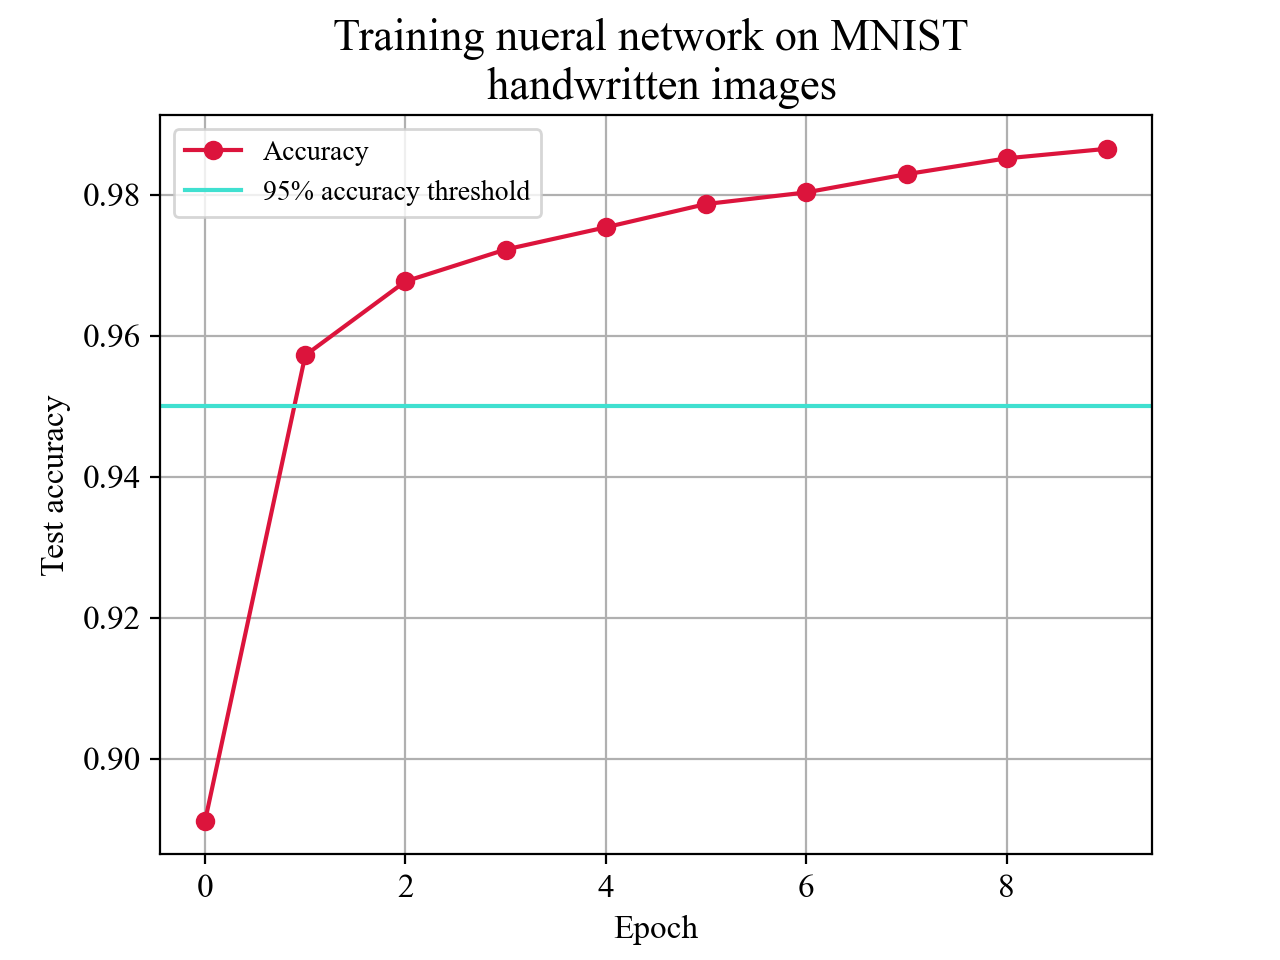

The final accuracy of the neural network is 98.65333437919617 %


In [6]:
#Plotting the accuracy of the network, aiming for a 95% accuracy

plt.figure(1)
plt.plot(np.arange(0,10), history.history['accuracy'], 'o-', color = 'crimson', label='Accuracy')
plt.axhline(y = 0.95, xmin = 0, xmax = 10, color = 'turquoise', label = '95% accuracy threshold')
plt.ylabel('Test accuracy')
plt.xlabel('Epoch')
plt.title('Training nueral network on MNIST \n handwritten images')
plt.legend(loc = 'best')
plt.grid()

print('The final accuracy of the neural network is', history.history['accuracy'][-1] * 100, '%')

### 2. Decomposing MNIST training dataset into PCA components

Code copied from Week5_PCA.ipynb Notebook, and converted into functions.

In [7]:
#Adapted from week 5 notebooks

def PCA_Components(images):
    '''Function which decomposes a set of images into their PCA components
    
    Input:
    images: array of images, an array of arrays of all the same size
    Returns: 
    x: normalised 2D image arrays
    mu: mean
    vecs: 1D array of eigenvectors
    vals: 1D array of eigenvalues'''
    
    #Turning the array of arrays into a 2D array
    X = np.reshape(images, (len(images[:,0,0]), 784))
    
    #Getting the mean of X
    mu = np.mean(X, axis = 0)
    
    x = X - mu
    
    rho = np.cov(x, rowvar = False)
    
    vals, vecs = linalg.eigh(rho)
    
    vals = np.flip(vals)
    vecs = np.flip(vecs)
    
    return x, mu, vecs, vals

(784,)


<IPython.core.display.Javascript object>


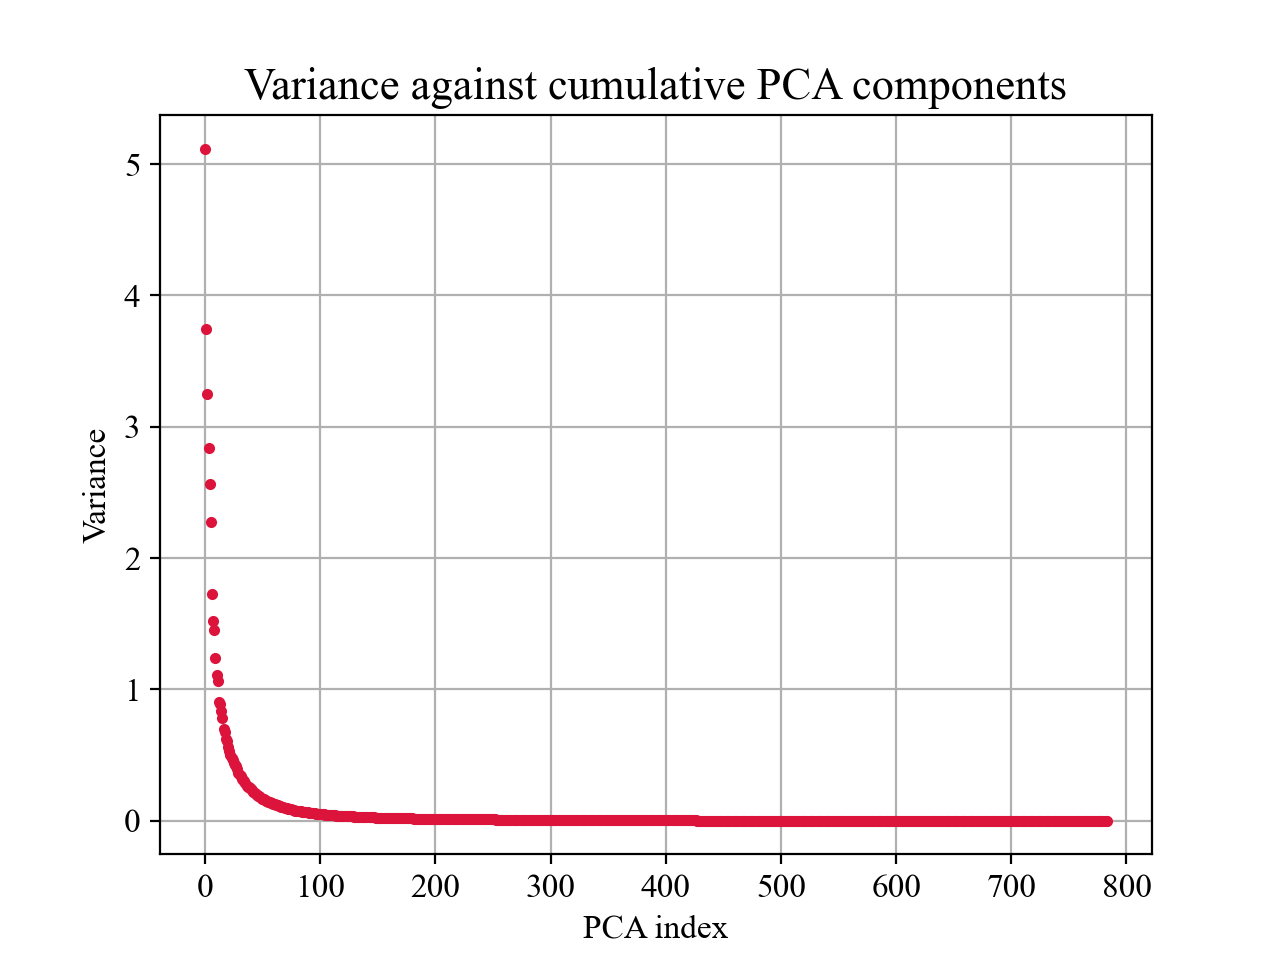

In [8]:
#Performing PCA on MNIST

x_train, mu_train, vecs_train, vals_train = PCA_Components(train_images)

print(np.shape(vals_train))

plt.figure(2)
plt.plot(np.arange((np.shape(vals_train)[0])),vals_train.real, '.', color='crimson')
plt.ylabel('Variance')
plt.xlabel('PCA index')
plt.title('Variance against cumulative PCA components')
plt.grid()

### 3. Plot of testing accuracy against N-best PCA components

In [9]:
x_test, mu_test, vecs_test, vals_test = PCA_Components(test_images)

In [10]:
def PCA_testing(model):
    '''Function which uses PCA componenets to test accuracy of a model
    Input:
    model: model to be tested
    Returns:
    test_accuracies: array of testing accuracy for each N PCA component'''

    test_accuracies = np.empty(len(N)) #initialising accuracy array
    
    #For each N value, analyse the accuracy of the model
    for i in range(len(N)):
    
        P = np.dot(x_test, vecs_test)
    
        new_image = (np.dot(P[:,0:N[i]], vecs_test.T[0:N[i], :])) + mu_test
    
        test_loss, test_accuracy = model.evaluate(new_image, test_labels, verbose = 0)
    
        test_accuracies[i] = test_accuracy
    
    return test_accuracies

<IPython.core.display.Javascript object>


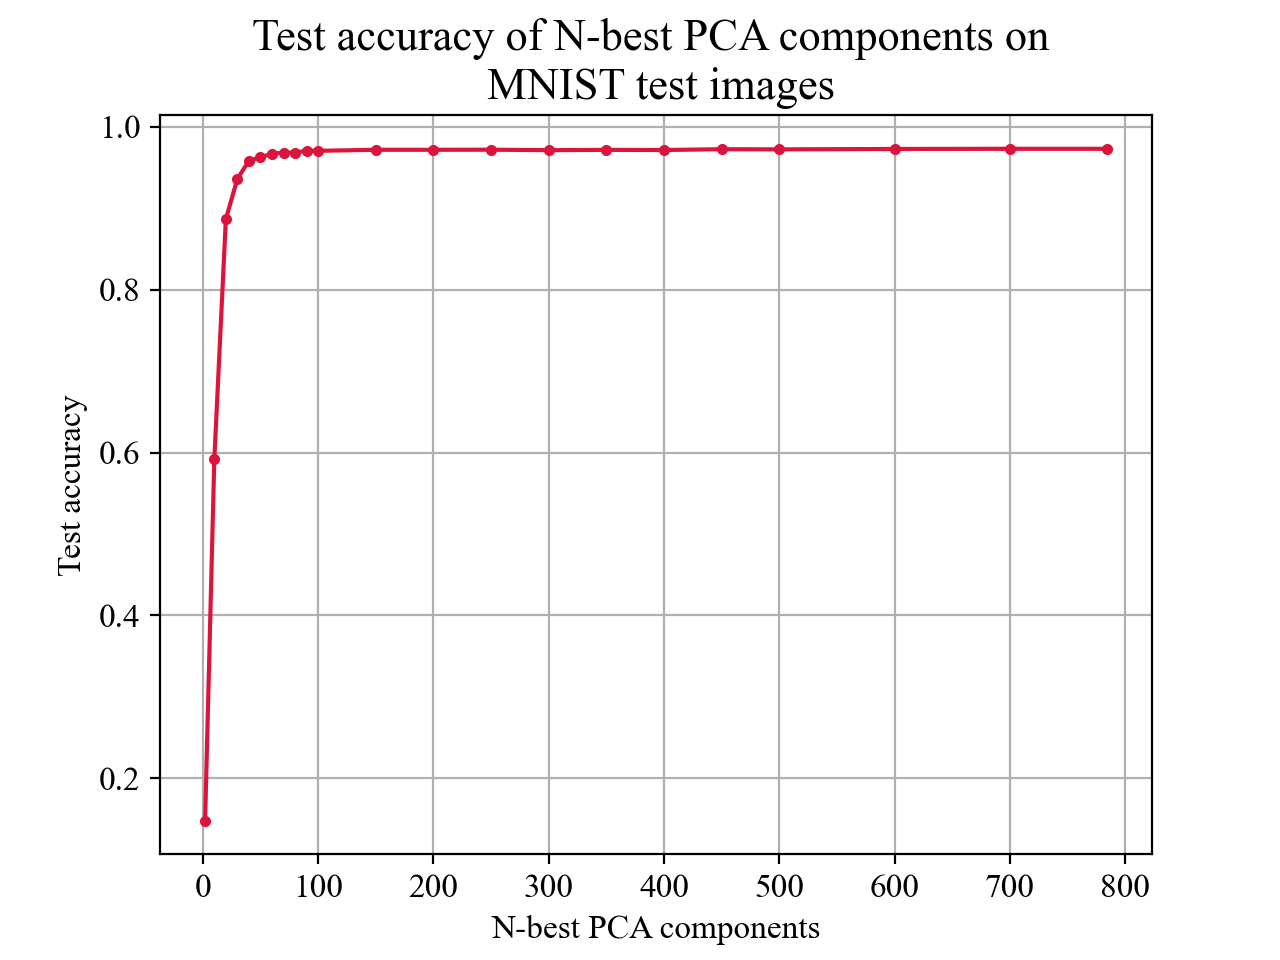

In [11]:
N_comps = PCA_testing(model)

plt.figure(3)
plt.plot(N, N_comps, '.-', color='crimson')
plt.xlabel('N-best PCA components')
plt.ylabel('Test accuracy')
plt.title('Test accuracy of N-best PCA components on \n MNIST test images')
plt.grid()

### 4. Retraining network on 100 best PCA components

In [12]:
# Now only using the 100 best PCA components

P = np.dot(x_train, vecs_train)

train_100 = (np.dot(P[:,0:100], vecs_train.T[0:100,:])) + mu_train #the 100 is for the 100 best
train_100 = np.reshape(train_100, (60000, 28, 28))

#Retrainging model on new training images

model_100 = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)), 
    keras.layers.Dense(128, activation = 'relu'), 
    keras.layers.Dense(15)
])

model_100.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = 1.0), metrics = ['accuracy'])

history = model_100.fit(train_100, train_labels, batch_size = 100, epochs = 10, 
                    validation_data = (test_images, test_labels))

Epoch 1/10
600/600 [==============================] - 1s 968us/step - loss: 0.4017 - accuracy: 0.8798 - val_loss: 0.1603 - val_accuracy: 0.9467
Epoch 2/10
600/600 [==============================] - 1s 855us/step - loss: 0.1509 - accuracy: 0.9534 - val_loss: 0.1335 - val_accuracy: 0.9582
Epoch 3/10
600/600 [==============================] - 1s 856us/step - loss: 0.1196 - accuracy: 0.9631 - val_loss: 0.1261 - val_accuracy: 0.9603
Epoch 4/10
600/600 [==============================] - 1s 866us/step - loss: 0.1022 - accuracy: 0.9688 - val_loss: 0.1019 - val_accuracy: 0.9705
Epoch 5/10
600/600 [==============================] - 1s 862us/step - loss: 0.0901 - accuracy: 0.9719 - val_loss: 0.1067 - val_accuracy: 0.9687
Epoch 6/10
600/600 [==============================] - 1s 857us/step - loss: 0.0827 - accuracy: 0.9741 - val_loss: 0.1111 - val_accuracy: 0.9678
Epoch 7/10
600/600 [==============================] - 1s 847us/step - loss: 0.0769 - accuracy: 0.9760 - val_loss: 0.0914 - val_accuracy:

### 5. Plot of testing accuracy against 100 N-best PCA components


<IPython.core.display.Javascript object>


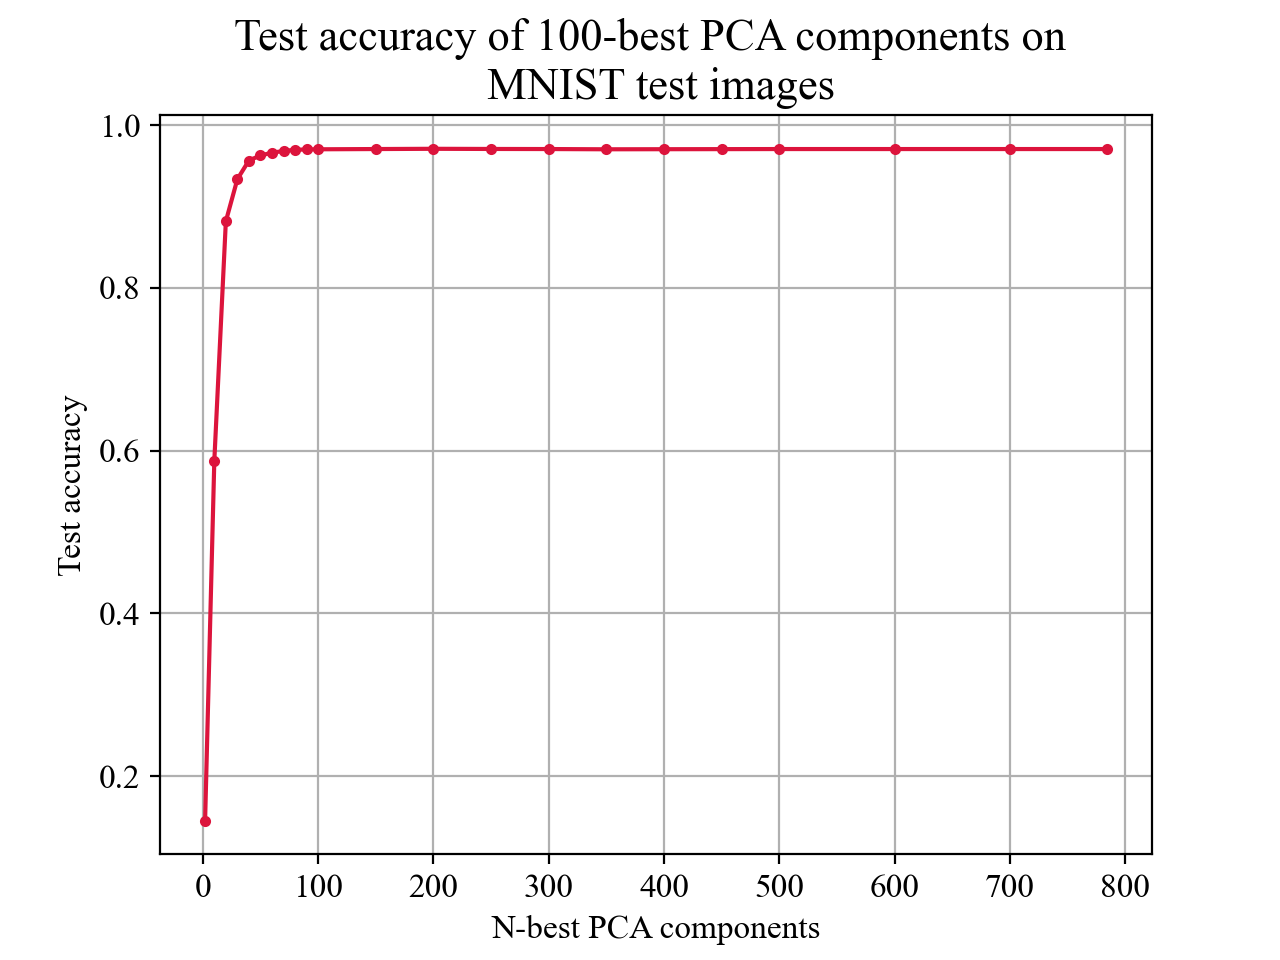

In [13]:
hundred_comps = PCA_testing(model_100)

plt.figure(4)
plt.plot(N, hundred_comps, '.-', color='crimson')
plt.xlabel('N-best PCA components')
plt.ylabel('Test accuracy')
plt.title('Test accuracy of 100-best PCA components on \n MNIST test images')
plt.grid()

### 6. Training and plotting of 20 best PCA components

In [14]:
# Now changing to 20 best

train_20 = (np.dot(P[:,0:20], vecs_train.T[0:20,:])) + mu_train
train_20 = np.reshape(train_20, (60000, 28, 28))

#Retrainging model on new training images

model_20 = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)), 
    keras.layers.Dense(128, activation = 'relu'), 
    keras.layers.Dense(15)
])

model_20.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = 1.0), metrics = ['accuracy'])

history = model_20.fit(train_20, train_labels, batch_size = 100, epochs = 10, 
                    validation_data = (test_images, test_labels))

Epoch 1/10
600/600 [==============================] - 1s 958us/step - loss: 0.6719 - accuracy: 0.7936 - val_loss: 0.4487 - val_accuracy: 0.8637
Epoch 2/10
600/600 [==============================] - 1s 868us/step - loss: 0.3261 - accuracy: 0.8993 - val_loss: 0.2707 - val_accuracy: 0.9173
Epoch 3/10
600/600 [==============================] - 1s 857us/step - loss: 0.2812 - accuracy: 0.9143 - val_loss: 0.2562 - val_accuracy: 0.9239
Epoch 4/10
600/600 [==============================] - 1s 871us/step - loss: 0.2600 - accuracy: 0.9226 - val_loss: 0.2661 - val_accuracy: 0.9185
Epoch 5/10
600/600 [==============================] - 1s 865us/step - loss: 0.2468 - accuracy: 0.9266 - val_loss: 0.3056 - val_accuracy: 0.9081
Epoch 6/10
600/600 [==============================] - 1s 862us/step - loss: 0.2388 - accuracy: 0.9287 - val_loss: 0.2331 - val_accuracy: 0.9302
Epoch 7/10
600/600 [==============================] - 1s 860us/step - loss: 0.2338 - accuracy: 0.9313 - val_loss: 0.2681 - val_accuracy:

<IPython.core.display.Javascript object>


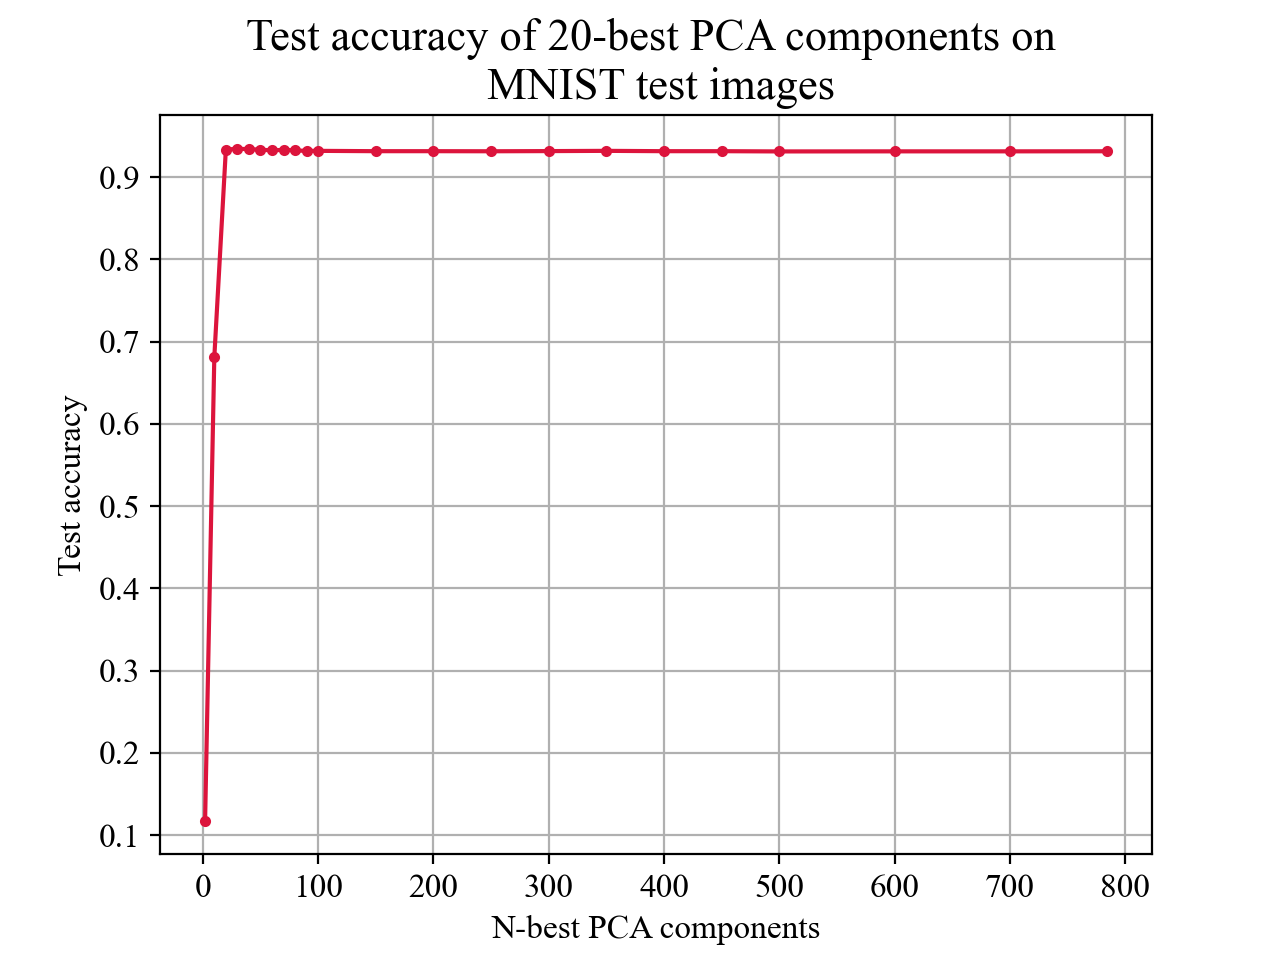

In [15]:
twenty_comps = PCA_testing(model_20)

plt.figure(5)
plt.plot(N, twenty_comps, '.-', color='crimson')
plt.xlabel('N-best PCA components')
plt.ylabel('Test accuracy')
plt.title('Test accuracy of 20-best PCA components on \n MNIST test images')
plt.grid()

<IPython.core.display.Javascript object>


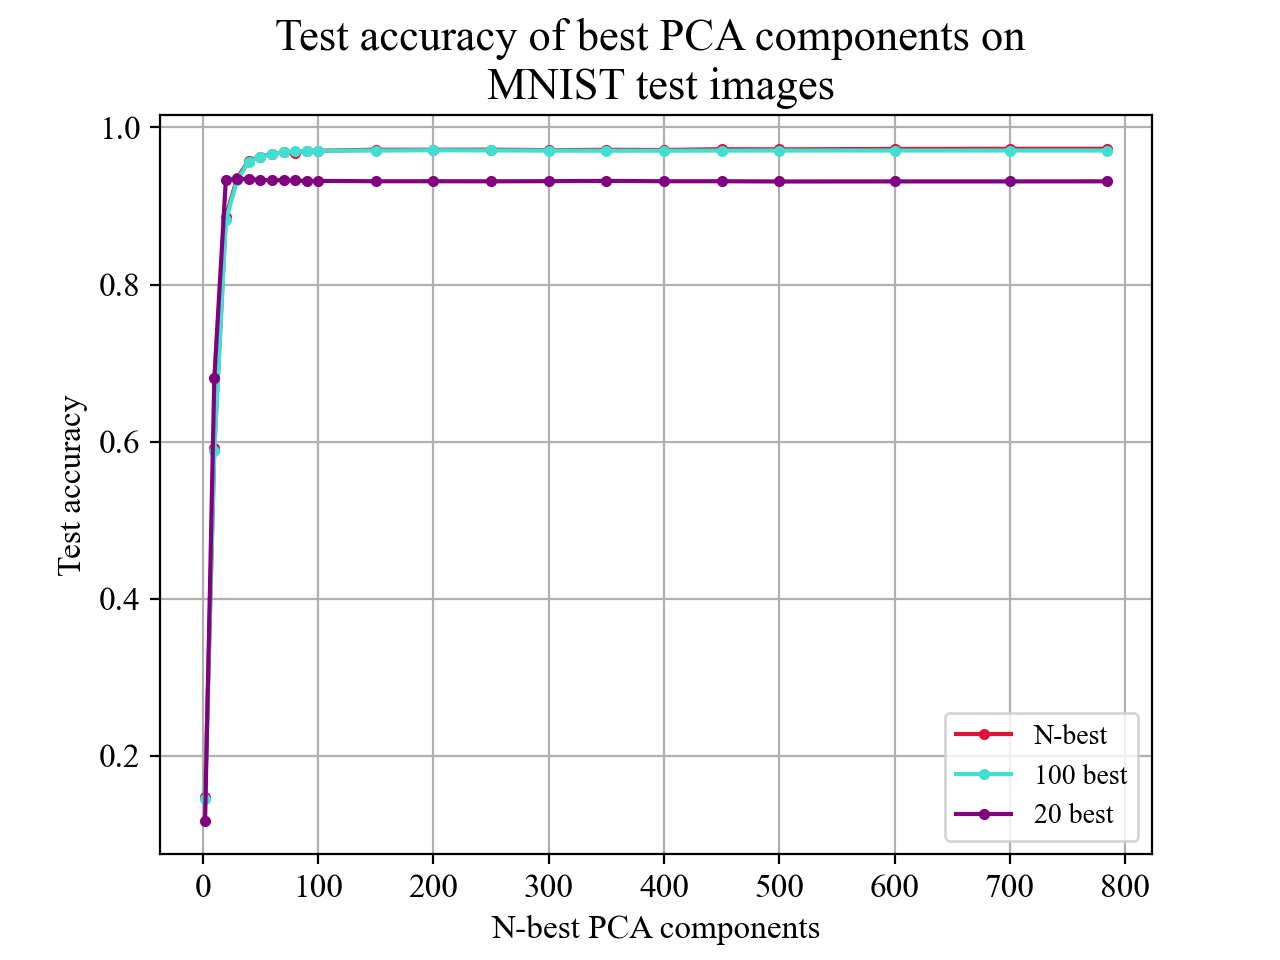

In [16]:
# Plot to compare all 3 models evaluated thus far

plt.figure(6)
plt.plot(N, PCA_testing(model), '.-', color='crimson', label = 'N-best')
plt.plot(N, PCA_testing(model_100), '.-', color='turquoise', label = '100 best')
plt.plot(N, PCA_testing(model_20), '.-', color='purple', label = '20 best')
plt.xlabel('N-best PCA components')
plt.ylabel('Test accuracy')
plt.title('Test accuracy of best PCA components on \n MNIST test images')
plt.legend(loc = 'best')
plt.grid()

<IPython.core.display.Javascript object>


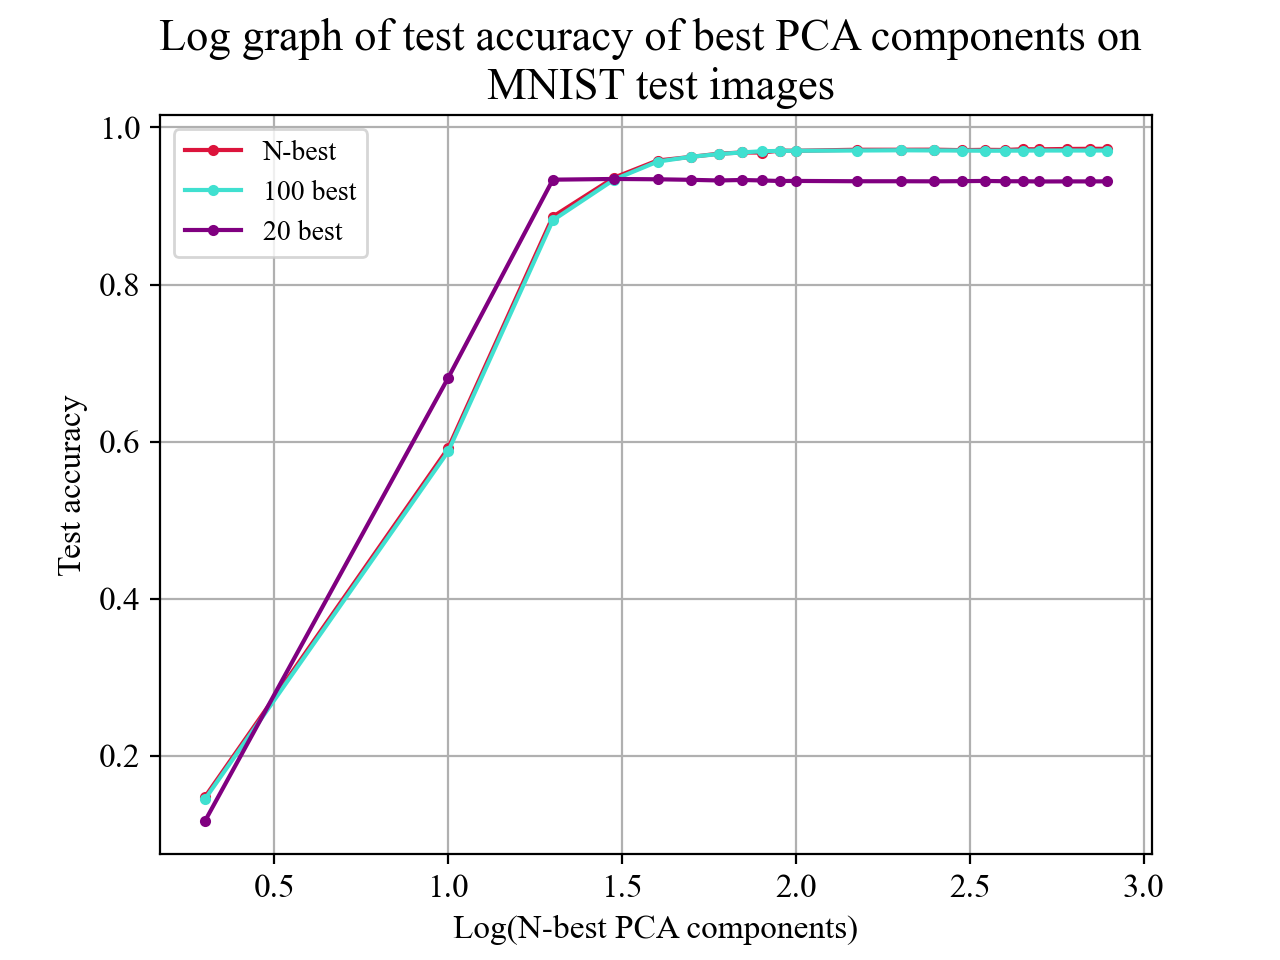

In [17]:
# Log plot, to better visualise the plateu effect

plt.figure(7)
plt.plot(np.log10(N), (PCA_testing(model)), '.-', color='crimson', label = 'N-best')
plt.plot(np.log10(N), (PCA_testing(model_100)), '.-', color='turquoise', label = '100 best')
plt.plot(np.log10(N), (PCA_testing(model_20)), '.-', color='purple', label = '20 best')
plt.xlabel('Log(N-best PCA components)')
plt.ylabel('Test accuracy')
plt.title('Log graph of test accuracy of best PCA components on \n MNIST test images')
plt.legend(loc = 'best')
plt.grid()

In [18]:
print('The final test accuracy for the first task is', N_comps[-1] * 100, '%')
print('The final test accuracy for the second task is', hundred_comps[-1] * 100, '%')
print('The final test accuracy for the third task is', twenty_comps[-1] * 100, '%')

The final test accuracy for the first task is 97.28000164031982 %
The final test accuracy for the second task is 97.06000089645386 %
The final test accuracy for the third task is 93.14000010490417 %


### 7 Conclusion

All 3 models are able to achieve high test accuracies, all above 90%, which was the threshold for the inital training of the model on the original MNIST images, so it is safe to say the PCA has achieved results comparable to a regular model.

From all the plots, it is clear that the accuracy increases rapidly at lower PCA indices. The accuracy then plateus, so that using more PCA components has no significant effect on accuracy. Specifically, about 30 PCA indices is enough to get accuracte results, and using more than this amount of PCA components is redundant.

Using 20 best PCA components is less accurate than using 100 best PCA components, which is understandable, using the 100 best makes the test images more closer to the validation images than using the 20 best components.

So in conclusion, out of the 784 PCA components availabe to use, you only need less than 50 on the MNIST images to get above 90% accuracy.